# Artificial Intelligence Image Classification using a proprietary indian snacks dataset 

Developed by Dharak Vasavda

I will train a convolutional neural network to recognize three different types of indian sweets known as mithai. 

## Prerequisites

Import Statements

In [205]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [206]:
import os

from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *

Global Batch Size. Reduce to ~16 this if using a small GPU.

In [207]:
batch_size=64

## Gathering Training Data

Set the path for the data

In [208]:
path = Path('data/snacks')

dest_gulab_jamun = path/'gulab_jamun'
dest_kaju_katli = path/'kaju_katli'
dest_laddoo = path/'laddoo'

dest_gulab_jamun.mkdir(parents=True, exist_ok=True)
dest_kaju_katli.mkdir(parents=True, exist_ok=True)
dest_laddoo.mkdir(parents=True, exist_ok=True)

Specify classes for the images

In [209]:
classes = ['kaju_katli', 'gulab_jamun', 'laddoo']

Download all images using urls from their respective urls_*.txt
All images will go into their respective data/snacks/... directory

In [210]:
download_images(path/'urls_gulab_jamun.txt', dest_gulab_jamun, max_pics=400)
download_images(path/'urls_kaju_katli.txt', dest_kaju_katli, max_pics=400)
download_images(path/'urls_laddoo.txt', dest_laddoo, max_pics=400)

Create our ImageDataBunch object. We can normalize our images to keep the same mean and standard deviation and improve performance. Images will be resized to 224x224 to maintain consistent GPU calculations.

In [211]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Visualize some of our data to verify we are on the right track.

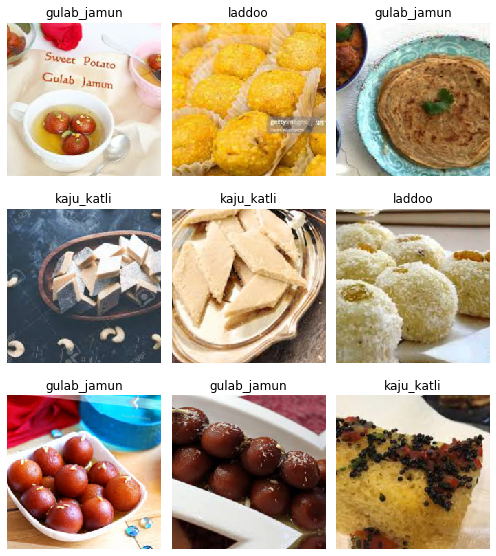

In [212]:
data.show_batch(rows=3, figsize=(7,8))

## Training the Model

A convolutional neural network (CNN) will be used for training the model.

CNN Input <- Images of the snacks

CNN Output -> Probability predicition of each class category

Begin with resnet34 for initial training. Resnet34 will come with pre-trained weights. There is a chance this may not work with full accuracy as indian sweets such as mithai are uncommon in traditional models. However using resent34 will help train much faster.

ImageDataBunch will be used as a validation set to prevent overfitting.

In [213]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Cycle through the dataset. Train with 4 epochs as a start.

In [214]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.219599,0.542213,0.161458,00:03
1,0.847184,0.577559,0.130208,00:03
2,0.637972,0.541718,0.135417,00:03
3,0.500868,0.515093,0.125000,00:03
4,0.411648,0.503497,0.125000,00:03


Only ~88% accuracy. We can unfreeze, fine-tune, and adjust our learning rate to improve this.

Save the model at this stage in time where:

- Initial training is completed
- No fine-tuning or learning rates have been adjusted

In [215]:
learn.save('stage-1')

## Fine-Tuning and Learning Rates

In [216]:
learn.unfreeze()

Learning rate and epochs can influence the accuracy of the model. Using a learning rate finder can help find the fastest rate at which the model can be trained before performance worsens.

In [217]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


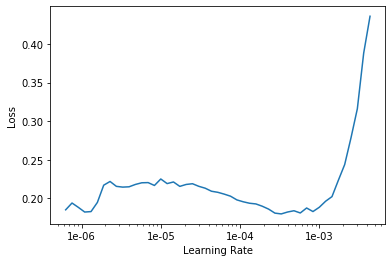

In [218]:
learn.recorder.plot()

Past 1e-03 is where loss of the model begins to ramp upwards. We can train again with the updated learning rate.

We can train the model with 2 more epochs as a start. Using the slice() function specifies the learning rate for the first and last layers.

In [219]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.284339,0.714962,0.130208,00:04
1,0.283075,0.440830,0.119792,00:04


Only ~88% accuracy. We can take this further by cleaning the dataset.

Save this model at a point in time where:

- Fine tuning is complete
- Learning rates have been adjusted

In [220]:
learn.save('stage-2')

## Interpreting the Model

ClassificationInterpretation will help interpret the model.

plot_top_losses() helps identify where the model was most wrong. It can identify when the model knows it has a wrong answer.

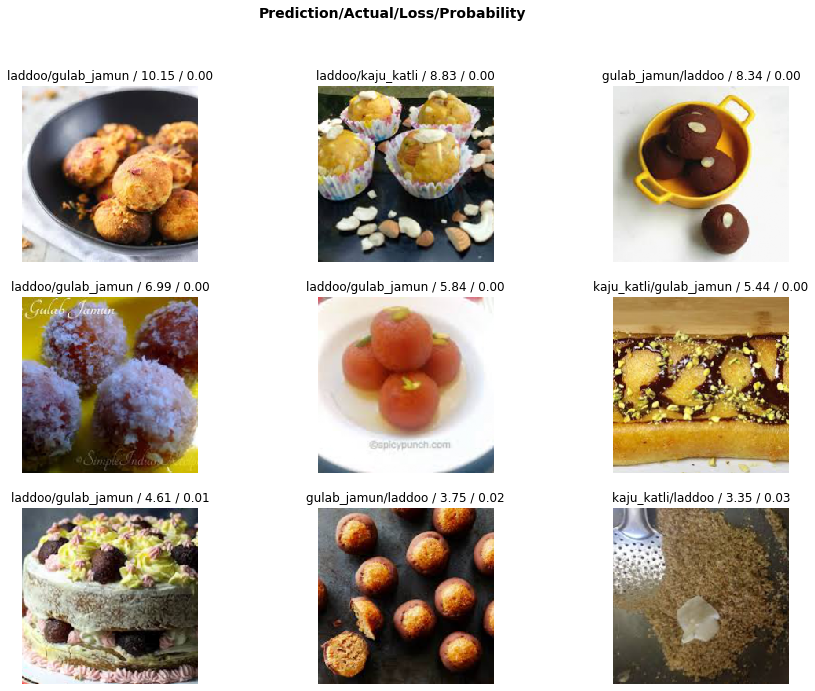

In [221]:
interp = ClassificationInterpretation.from_learner(learn) 

interp.plot_top_losses(9, figsize=(15,11))

most_confused() shows which classes were most confusing to the model.

In [222]:
interp.most_confused(min_val=2)

[('gulab_jamun', 'kaju_katli', 5),
 ('gulab_jamun', 'laddoo', 5),
 ('laddoo', 'gulab_jamun', 5),
 ('laddoo', 'kaju_katli', 4),
 ('kaju_katli', 'laddoo', 3)]

## Cleaning the Data

### Cleaning High Losses

Print out a confusion matrix to indicate where the data needs to be cleaned

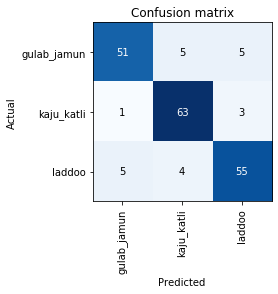

In [223]:
learn.load('stage-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The first cleaning will involve verifying and removing the highest losses

ImageCleaner will not delete the images, but rather will generate a new CSV (cleaned.csv) with the list of pictures that are not for remove, along with the correct categories

In [224]:
db = (ImageList.from_folder(path)
        .split_none()
        .label_from_folder()
        .transform(get_transforms(), size=224)
        .databunch())

learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

Create a new learn_cln model and transfer the weights of the previous stage-2 

Separate the dataset and the indicies from the main training losses.

In [225]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Click 'Delete' on any image which doesn't belong in the dataset. After clicking 'Next Batch', an updated cleaned.csv will be generated with the removal of the deleted data's indicies

### Cleaning Duplicates

Cleaning duplicate data is important. We can remove it from our dataset and update cleaned.csv 

In [226]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## The Model after Image Cleaning

We will need to regenerate the DataBunch (The Data Frame with the images and their labels)

This time, we will use the updated cleaned.csv file for our data indicators

In [229]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
        .split_none()
        .label_from_df()
        .transform(get_transforms(), size=224)
        .databunch())

Re-train the model with our newer, cleaner dataset 

In [230]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.fit_one_cycle(2, max_lr=slice(3e-5,3e-3))

Our error rate is now #na#. We reached 100% accuracy!

## Takeaways

The model prediction finished with a 100% accuracy with only 9 total epochs of training and < 1,000 images. In order to take this further, we can try:

- Expanding the dataset
- Tuning the epochs
- Trying different learning rates
- Tuning batch size
- Using more layers with resnet50 instead of resnet34